In [1]:
import os
import sys
import argparse
import logging
from tqdm import tqdm

import torch

import cv2
import numpy as np
import matplotlib.pyplot as plt

from densebody_poc.utils import config_util, validation_util, model_util
from densebody_poc.datasets.densebody_dataset import DenseBodyDataset
from densebody_poc.datasets.visualizer import Visualizer
from densebody_poc.exceptions.model_error import ModelNotFoundError
from densebody_poc.exceptions.conf_error import InvalidJsonConfigError

from densebody_poc.utils.constants import JOB_CONF_KEY, BATCH_SIZE_KEY, MAX_DATASET_SIZE_KEY

In [2]:
def handle_error(e):
    '''
    Error handling during the prediction dataflow
    '''
    logging.error(str(e) + '\n...Exiting program...')
    sys.exit(0)

initialize network with xavier
initialize network with xavier
Checkpoints loaded from epoch 200
---------- Networks initialized -------------
ResNetEncoder(
  (conv): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvResBlock(
      (res): BasicResBlock(
        (activation_layer): LeakyReLU(negative_slope=0.2, inplace=True)
        (res): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

Predicting case 0:   0%|                                  | 0/2 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processed data 0


Predicting case 1:  50%|█████████████             | 1/2 [00:00<00:00,  2.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processed data 1


Predicting case 1: 100%|██████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


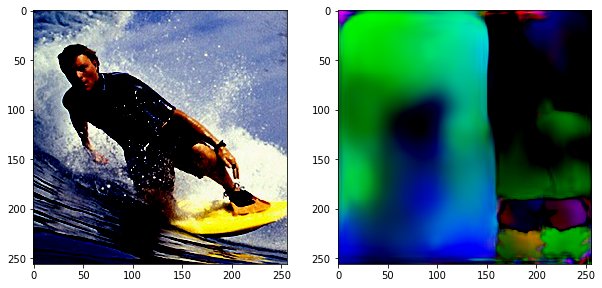

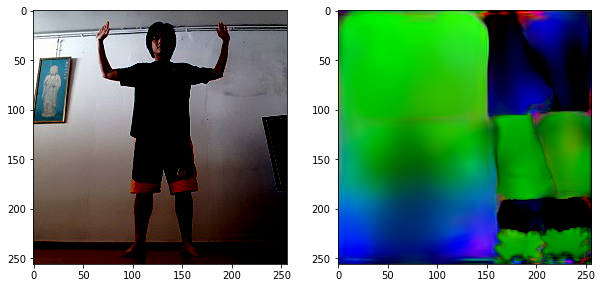

In [4]:
conf = config_util.get_json_conf('../conf/notebook_predict_conf.json')
# TODO: Add validation -> validation_util.validate_user_conf(conf)
try:
    validation_util.validate_user_conf(conf)
except InvalidJsonConfigError as e:
    handle_error(e)

try:
    dataset = DenseBodyDataset(conf)
except FileNotFoundError as e:
    handle_error(e)

batches_per_epoch = max(len(dataset) // conf[JOB_CONF_KEY][BATCH_SIZE_KEY], 1)
logging.info('Predicting {} images'.format(len(dataset)))

# TODO: implement model objects
# model = create_model()
try:
    model = model_util.get_model(conf)
    model.initialize(conf)
    model.setup(conf)
    print(model)
except ModelNotFoundError as e:
    handle_error(e)

# TODO: implement visualizer
visualizer = Visualizer(conf)

with torch.no_grad():
    dataset_iter = tqdm(range(len(dataset)), ncols=80)
    for i in dataset_iter:
        dataset_iter.set_description('Predicting case {}'.format(i))
        try:
            data = dataset[i]
        except TypeError as e:
            logging.error('Issue processing data {} in dataset\n'.format(i) + str(e))
            continue

        # TODO implement setting of input data to model, and passing data into encoder/decoder
        model.set_input(data)
        
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(121)
        ax.imshow(
            cv2.cvtColor(
                np.transpose(data['im_data'][0].cpu().numpy(), (1, 2, 0)),
                cv2.COLOR_BGR2RGB
            )
        )
        
        enc_out = model.encoder(model.real_input)
        model.fake_UV = model.decoder(enc_out)

        # TODO: Implement saving of results
        # visualizer.save_results(model.get_current_visuals(), opt.load_epoch, i)
        ax = plt.subplot(122)
        ax.imshow(np.transpose(model.fake_UV[0].cpu().numpy(), (1, 2, 0)))
        plt.plot()

        print('Processed data {}'.format(i))